In [1]:
import spacy 
import re 
import pandas as pd
from spacy.lang.en import English
from collections import Counter
from itertools import chain
import ahocorasick
import ast
from analyze_m_data import get_occupations_list_en, get_occupations_list
from spacy.lang.de import German
from spacy.lang.it import Italian
from spacy.lang.es import Spanish 
import matplotlib.pyplot as plt
import itertools
from collections import Counter
from operator import itemgetter

In [57]:
de_female_df = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/sets_for_analysis/de_female_occ_all_sentences_fulldata.csv', encoding="utf-8")

In [4]:
print(de_female_df.columns)

Index(['Unnamed: 0', 'wikidata_code', 'title', 'intro', 'gender',
       'occupations', 'first_sentence', 'named_entities',
       'overlapping_occupations_male',
       'overlapping_occupations_sentence1_male',
       'overlapping_occupations_female',
       'overlapping_occupations_sentence1_female'],
      dtype='object')


In [5]:
def new_german_analysis(df):
    #Want to: 
    # 1. Split up german occupation titles list into two lists: one token occupations and multi token
    # 2. For one token occupations, want to find matches (in first sentence) with hard word boundaries (like in german code)
    # 3. For multi token occupations, want to just look up matches 
    # 4. Want to remove named entities from matched tokens in that line 
    # 5. Want to get final matched titles list 
    df['intro'] = df['intro'].astype(str)
    df['first_sentence'] = df['first_sentence'].astype(str)
    df['named_entities'] = df['named_entities'].apply(ast.literal_eval)
    df['named_entities'] = df['named_entities'].apply(lambda x: [item.casefold() for item in x])
    df['overlapping_occupations_sentence1_female'] = df['overlapping_occupations_sentence1_female'].apply(ast.literal_eval)
    df['overlapping_occupations_sentence1_male'] = df['overlapping_occupations_sentence1_male'].apply(ast.literal_eval)
    print("hello")
    print(df['named_entities'].head(10))
    
    def filter_NER(row):
        col1_counts = Counter(row['overlapping_occupations_sentence1_male'])  # Count occurrences in col1
        col2_counts = Counter(row['named_entities'])  # Count occurrences in col2

        # Remove only up to the number of times they appear in col2
        for word, count in col2_counts.items():
            if word in col1_counts:
                col1_counts[word] -= count  # Reduce count but not below zero
                if col1_counts[word] <= 0:
                    del col1_counts[word]  # Remove word if count reaches zero

        # Reconstruct the filtered list based on updated counts
        filtered_list = []
        for word, count in col1_counts.items():
            filtered_list.extend([word] * count)  # Add back only remaining occurrences

        return filtered_list
    df['overlapping_occupations_sentence1_male'] = df.apply(
    lambda row: [item for item in row['overlapping_occupations_sentence1_male'] if item != row['title']],
    axis=1
)

    def remove_geborene(row):
    # Find all words that are preceded by "geborene"
        geborene_matches = re.findall(r'geborene\s+(\w+)', row['first_sentence'])
        # Remove those words from the list
        return [item for item in row['overlapping_occupations_sentence1_male'] if item not in geborene_matches]
    
    def filter_male_names(row):
        return [item for item in row['overlapping_occupations_sentence1_male']
            if all(item not in s for s in row['named_entities'])]
    # remove named entities from matched occupations
    df['overlapping_occupations_sentence1_male'] = df.apply(filter_NER, axis=1)
    df['overlapping_occupations_sentence1_male'] = df.apply(remove_geborene, axis=1)
    df['overlapping_occupations_sentence1_male'] = df.apply(filter_male_names, axis=1)
    # df['overlapping_occupations_sentence1_female'] = df.apply(filter_NER, axis=1)
    # print(df['overlapping_occupations_sentence1_female'].head(10))
    filtered_df = df[df['overlapping_occupations_sentence1_male'].apply(lambda x: 'müller' in x)]
    print(filtered_df.head())

In [13]:
new_german_analysis(de_female_df)
overlapping_occ_counts_s1_female_all = Counter(chain.from_iterable(de_female_df['overlapping_occupations_sentence1_female']))
overlapping_occ_counts_s1_female_all_male = Counter(chain.from_iterable(de_female_df['overlapping_occupations_sentence1_male']))
print(overlapping_occ_counts_s1_female_all)
print(overlapping_occ_counts_s1_female_all_male)
occ_titles_found_female = de_female_df[de_female_df['overlapping_occupations_sentence1_female'].map(len)>0]
print(de_female_df.shape[0])
print(occ_titles_found_female.shape[0])

hello
0    [emmi, agathe, karola, wiltraut, rupp-von, brü...
1    [sylvia, bayr-klimpfinger, wien, österreich-un...
2                 [ulrike, scheel, dortmund, deutsche]
3                             [renee, goddard, berlin]
4      [isabella, kossina, wien, österreichische, spö]
5    [florina, gillnik, königswinter, florentine, e...
6    [christina, kauschke, dortmund, philipps-unive...
7    [susana, kasakoff, buenos, aires, argentinisch...
8       [heike, marianne, goetze, osnabrück, deutsche]
9    [irmgard, marie, elisabeth, von, witzleben, ar...
Name: named_entities, dtype: object
       Unnamed: 0 wikidata_code                          title  \
3797         3811      Q1332607          elly-viola nahmmacher   
9719         9756     Q15832759  lotte müller (schauspielerin)   
10496       10539      Q1596524                    maria röder   
16850       16921      Q1866464                    livia kádár   
24064       24169      Q2338246    stefanie müller (badminton)   

           

In [ ]:
new_german_analysis(de_female_df)
overlapping_occ_counts_s1_female_all = Counter(chain.from_iterable(de_female_df['overlapping_occupations_sentence1_female']))
overlapping_occ_counts_s1_female_all_male = Counter(chain.from_iterable(de_female_df['overlapping_occupations_sentence1_male']))
print(overlapping_occ_counts_s1_female_all)
print(overlapping_occ_counts_s1_female_all_male)
occ_titles_found_female = de_female_df[de_female_df['overlapping_occupations_sentence1_female'].map(len)>0]
print(de_female_df.shape[0])
print(occ_titles_found_female.shape[0])


hello
0    [emmi, agathe, karola, wiltraut, rupp-von, brü...
1    [sylvia, bayr-klimpfinger, wien, österreich-un...
2                 [ulrike, scheel, dortmund, deutsche]
3                             [renee, goddard, berlin]
4      [isabella, kossina, wien, österreichische, spö]
5    [florina, gillnik, königswinter, florentine, e...
6    [christina, kauschke, dortmund, philipps-unive...
7    [susana, kasakoff, buenos, aires, argentinisch...
8       [heike, marianne, goetze, osnabrück, deutsche]
9    [irmgard, marie, elisabeth, von, witzleben, ar...
Name: named_entities, dtype: object
       Unnamed: 0 wikidata_code                          title  \
3797         3811      Q1332607          elly-viola nahmmacher   
9719         9756     Q15832759  lotte müller (schauspielerin)   
10496       10539      Q1596524                    maria röder   
16850       16921      Q1866464                    livia kádár   
24064       24169      Q2338246    stefanie müller (badminton)   

           

In [27]:
new_german_analysis(de_female_df)
overlapping_occ_counts_s1_female_all = Counter(chain.from_iterable(de_female_df['overlapping_occupations_sentence1_female']))
overlapping_occ_counts_s1_female_all_male = Counter(chain.from_iterable(de_female_df['overlapping_occupations_sentence1_male']))
print(overlapping_occ_counts_s1_female_all)
print(overlapping_occ_counts_s1_female_all_male)
occ_titles_found_female = de_female_df[de_female_df['overlapping_occupations_sentence1_female'].map(len)>0]
print(occ_titles_found_female.shape[0])

hello
0    [emmi, agathe, karola, wiltraut, rupp-von, brü...
1    [sylvia, bayr-klimpfinger, wien, österreich-un...
2                 [ulrike, scheel, dortmund, deutsche]
3                             [renee, goddard, berlin]
4      [isabella, kossina, wien, österreichische, spö]
5    [florina, gillnik, königswinter, florentine, e...
6    [christina, kauschke, dortmund, philipps-unive...
7    [susana, kasakoff, buenos, aires, argentinisch...
8       [heike, marianne, goetze, osnabrück, deutsche]
9    [irmgard, marie, elisabeth, von, witzleben, ar...
Name: named_entities, dtype: object
Counter({'schauspielerin': 4627, 'politikerin': 4392, 'schriftstellerin': 2497, 'autorin': 2037, 'journalistin': 1391, 'sängerin': 1129, 'badmintonspielerin': 913, 'künstlerin': 810, 'fussballspielerin': 783, 'opernsängerin': 640, 'professorin': 611, 'synchronsprecherin': 598, 'malerin': 568, 'historikerin': 546, 'regisseurin': 529, 'übersetzerin': 512, 'theaterschauspielerin': 480, 'hochschullehrerin': 4

In [33]:
def make_plot1(overlapping_occ_counts):
    # get bar chart of top 20 occupations
    ten_items = dict(sorted(overlapping_occ_counts.items(), key=itemgetter(1), reverse=True)[:20])
    print(ten_items)
    plt.bar(range(len(ten_items)), list(ten_items.values()), align='center')
    plt.xticks(range(len(ten_items)), list(ten_items.keys()))
    plt.xticks(rotation=90)
    plt.title("Occurences of Occupation Titles in Female Data")
    plt.show()

In [18]:
def make_plot(overlapping_occ_counts):
    # get bar chart of top 20 occupations
    ten_items = dict(sorted(overlapping_occ_counts.items(), key=itemgetter(1), reverse=True)[:30])
    print(ten_items)
    values = list(ten_items.values())
    values = [float(i) for i in values]
    values_sum = sum(values)
    print(values_sum)
    averages = [x / values_sum for x in values]
    print(averages[:10])
    plt.bar(range(len(ten_items)), averages, align='center')
    plt.xticks(range(len(ten_items)), list(ten_items.keys()))
    plt.xticks(rotation=90)
    plt.title("Percentage of Occupational Title Occurences in German Male Data")
    plt.show()

In [16]:
de_male_df = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/sets_for_analysis/de_male_occ_all_sentences_fulldata.csv', encoding="utf-8")

In [17]:
new_german_analysis(de_male_df)
overlapping_occ_counts_s1_male_all = Counter(chain.from_iterable(de_male_df['overlapping_occupations_sentence1_male']))
overlapping_occ_counts_s1_male_all_female = Counter(chain.from_iterable(de_male_df['overlapping_occupations_sentence1_female']))
print(overlapping_occ_counts_s1_male_all)
print(overlapping_occ_counts_s1_male_all_female)
occ_titles_found_male = de_male_df[de_male_df['overlapping_occupations_sentence1_male'].map(len)>0]
print(de_female_df.shape[0])
print(occ_titles_found_male.shape[0])

hello
0    [heinz, eduard, tödt, wester, hannover, deutsc...
1               [john, oduke, acholiland, ugandischer]
2    [johann, rockenthien, sekundogenitur, sachsen-...
3    [volker, wagner, deutscher, kenianischen, zeit...
4                [heinrich, von, arx, bern, schweizer]
5    [fritz, b., simon, siegen, deutscher, palo, al...
6                    [richard, alff, essen, deutscher]
7    [peter, graf, zu, rantzau, kloster, uetersen, ...
8    [siegmund, werner, wien, österreich-ungarn, zu...
9             [paul, roscher, pockau, deutscher, kpd-]
Name: named_entities, dtype: object
       Unnamed: 0 wikidata_code                       title  \
14656        2695      Q1535969                michl müller   
29548        5623     Q15431987  karl wilhelm theodor hauck   

                                                   intro gender  \
14656  michael „michl“ müller (* 10. märz 1972 in bad...   male   
29548  karl wilhelm theodor hauck (* 28. september 17...   male   

                

In [ ]:
interesting_occ_title_list = ['Krankenpfleger', 'Krankenpflegerin', 'Krankenschwester',"Pfleger","Pflegerin",'Hebamme', 'Geburtshelfer', 'Geburtshelferin', 'Geburtshelfende','Sekretärin', 'Assistenz','Putzfrau', 'Reinigungskraft', 'Putzhilfe','Zimmermädchen', 'Zimmerservice']
lowercase_list = [item.lower() for item in interesting_occ_title_list]
de_female_df['first_sentence'] = de_female_df['first_sentence'].astype(str)
automaton = ahocorasick.Automaton()
for id, term in enumerate(lowercase_list):
    automaton.add_word(term, (term))
automaton.make_automaton()
def find_terms(text):
        words = list(re.findall(r'\b\w+\b', text.lower()))  # Tokenize text into words
        matches = list(term for _, term in automaton.iter(text) if term.lower() in words)
        return matches

de_female_df['gendered_titles'] = de_female_df['first_sentence'].apply(find_terms)
overlapping_occ_counts_female_interesting= Counter(chain.from_iterable(de_female_df['gendered_titles']))

In [29]:
print(overlapping_occ_counts_female_interesting)

Counter({'krankenschwester': 69, 'hebamme': 25, 'sekretärin': 14, 'krankenpflegerin': 9, 'pflegerin': 5, 'geburtshelferin': 3, 'pfleger': 1, 'zimmermädchen': 1, 'assistenz': 1})


{'krankenschwester': 69, 'hebamme': 25, 'sekretärin': 14, 'krankenpflegerin': 9, 'pflegerin': 5, 'geburtshelferin': 3, 'pfleger': 1, 'zimmermädchen': 1, 'assistenz': 1}


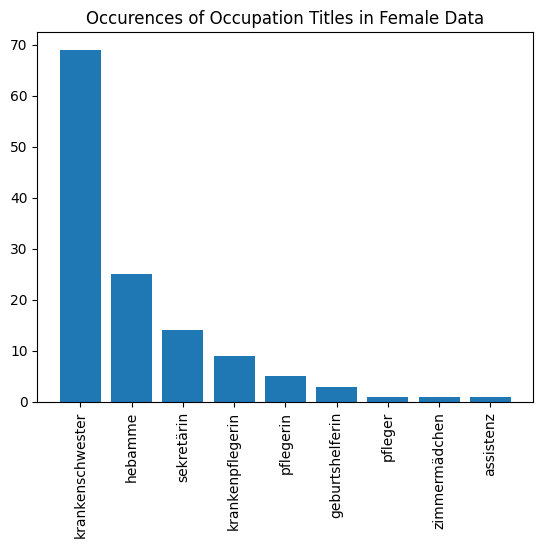

In [37]:
make_plot1(overlapping_occ_counts_female_interesting)

In [31]:
interesting_occ_title_list = ['Krankenpfleger', 'Krankenpflegerin', 'Krankenschwester',"Pfleger","Pflegerin",'Hebamme', 'Geburtshelfer', 'Geburtshelferin', 'Geburtshelfende','Sekretärin', 'Assistenz','Putzfrau', 'Reinigungskraft', 'Putzhilfe','Zimmermädchen', 'Zimmerservice']
lowercase_list = [item.lower() for item in interesting_occ_title_list]
de_male_df['first_sentence'] = de_male_df['first_sentence'].astype(str)
automaton = ahocorasick.Automaton()
for id, term in enumerate(lowercase_list):
    automaton.add_word(term, (term))
automaton.make_automaton()
def find_terms(text):
        words = list(re.findall(r'\b\w+\b', text.lower()))  # Tokenize text into words
        matches = list(term for _, term in automaton.iter(text) if term.lower() in words)
        return matches

de_male_df['gendered_titles'] = de_male_df['first_sentence'].apply(find_terms)
overlapping_occ_counts_male_interesting= Counter(chain.from_iterable(de_male_df['gendered_titles']))
print(overlapping_occ_counts_male_interesting)

Counter({'geburtshelfer': 22, 'pfleger': 5, 'krankenpfleger': 2})


{'geburtshelfer': 22, 'pfleger': 5, 'krankenpfleger': 2}


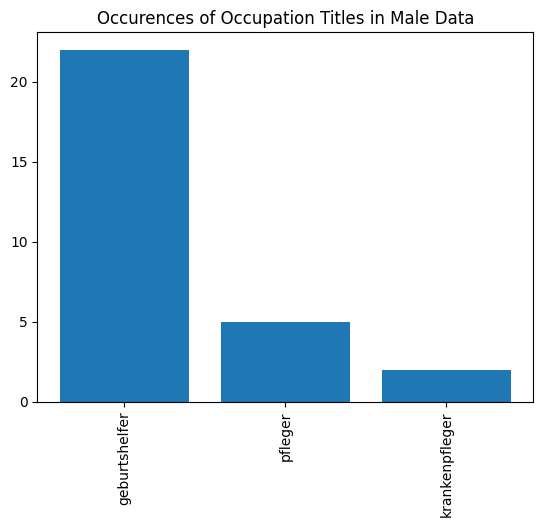

In [32]:
make_plot1(overlapping_occ_counts_male_interesting)

{'schauspielerin': 4627, 'politikerin': 4392, 'schriftstellerin': 2497, 'autorin': 2037, 'journalistin': 1391, 'sängerin': 1129, 'badmintonspielerin': 913, 'künstlerin': 810, 'fussballspielerin': 783, 'opernsängerin': 640, 'professorin': 611, 'synchronsprecherin': 598, 'malerin': 568, 'historikerin': 546, 'regisseurin': 529, 'übersetzerin': 512, 'theaterschauspielerin': 480, 'hochschullehrerin': 449, 'juristin': 425, 'moderatorin': 418, 'fernsehmoderatorin': 411, 'komponistin': 406, 'drehbuchautorin': 375, 'kunsthistorikerin': 372, 'abgeordnete': 352, 'pianistin': 323, 'bildhauerin': 317, 'biathletin': 313, 'lehrerin': 302, 'pädagogin': 301}
27827.0
[0.16627735652423906, 0.15783232112696302, 0.08973299313616272, 0.0732022855500054, 0.04998742228770618, 0.0405721062277644, 0.03280986092643835, 0.02910841987997269, 0.028138139217306932, 0.022999245337262372]


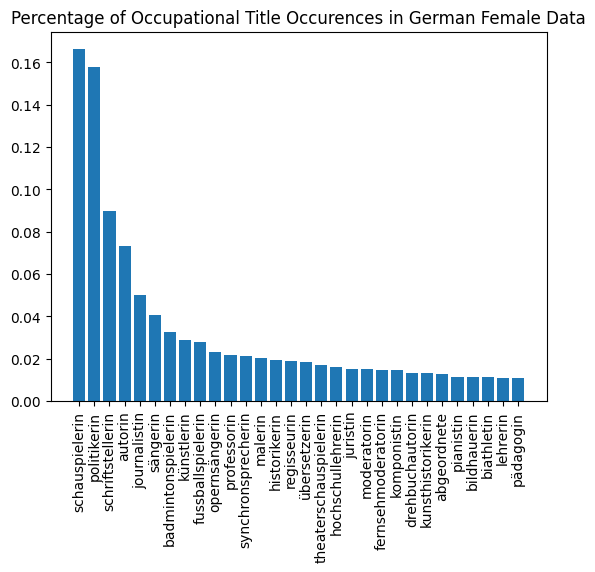

In [9]:
make_plot(overlapping_occ_counts_s1_female_all)

{'politiker': 4653, 'jurist': 1369, 'fussballspieler': 1233, 'maler': 1164, 'autor': 1150, 'schriftsteller': 1102, 'schauspieler': 1090, 'hochschullehrer': 1033, 'theologe': 951, 'komponist': 932, 'journalist': 859, 'professor': 786, 'historiker': 700, 'unternehmer': 672, 'architekt': 654, 'bildhauer': 526, 'musiker': 473, 'diplomat': 463, 'bürgermeister': 401, 'regisseur': 389, 'künstler': 356, 'grafiker': 352, 'arzt': 352, 'lehrer': 338, 'pädagoge': 336, 'eishockeyspieler': 331, 'geistlicher': 329, 'kommunalpolitiker': 327, 'kaufmann': 324, 'generalmajor': 319}
23964.0
[0.1941662493740611, 0.0571273577032215, 0.0514521782674011, 0.0485728592889334, 0.04798864964112836, 0.04598564513436822, 0.04548489400767818, 0.043106326155900515, 0.039684526790185276, 0.038891670839592725]


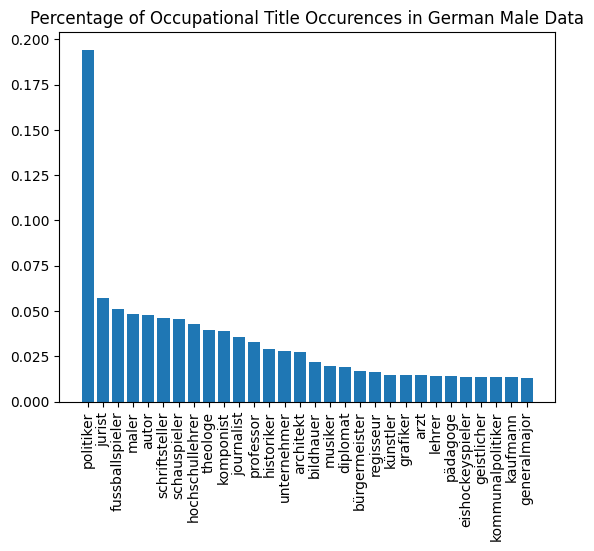

In [19]:
make_plot(overlapping_occ_counts_s1_male_all)

In [38]:
import gzip
filename = "/mount/studenten/projects/caulfiea/cross-verified-database.csv.gz"
csvFilename = gzip.open(filename, 'rb')
df = pd.read_csv(csvFilename, encoding='latin-1')
print(df.head(10))
print(df.columns)

  wikidata_code   birth   death  updated_death_date approx_birth approx_death  \
0      Q1000002  1932.0  1990.0                 NaN          NaN          NaN   
1      Q1000005  1860.0  1927.0                 NaN          NaN          NaN   
2      Q1000006  1971.0     NaN                 NaN          NaN          NaN   
3      Q1000015  1983.0     NaN                 NaN          NaN          NaN   
4      Q1000023  1912.0  1977.0                 NaN          NaN          NaN   
5      Q1000026  1928.0  2016.0                 NaN          NaN          NaN   
6      Q1000034  1818.0  1894.0                 NaN          NaN          NaN   
7      Q1000044  1907.0  1980.0                 NaN          NaN          NaN   
8      Q1000045  1915.0  1987.0                 NaN          NaN        circa   
9      Q1000048  1891.0  1962.0                 NaN          NaN          NaN   

   birth_min  birth_max  death_min  death_max  ... area2_of_rattachment  \
0     1932.0     1932.0     1990.

In [58]:
de_female_codes = de_female_df['wikidata_code'].to_list()
df2 = df.loc[df['wikidata_code'].isin(de_female_codes)]
print(df2.shape[0])

36874


In [59]:
notability_scores = df2[['wikidata_code','number_wiki_editions','sum_visib_ln_5criteria']]
result = pd.merge(de_female_df, notability_scores, on='wikidata_code')
result['overlapping_occupations_sentence1_female'] = result['overlapping_occupations_sentence1_female'].apply(ast.literal_eval)
print(result.head())

   Unnamed: 0 wikidata_code                       title  \
0           0      Q1000023  wiltraut rupp-von brünneck   
1           1      Q1000044     sylvia bayr-klimpfinger   
2           2      Q1000089               ulrike scheel   
3           3      Q1000204               renee goddard   
4           4      Q1000310            isabella kossina   

                                               intro  gender  \
0  emmi agathe karola margarete wiltraut rupp-von...  female   
1  sylvia bayr-klimpfinger (* 1. august 1907 in w...  female   
2  ulrike scheel (* im 20. jahrhundert in dortmun...  female   
3  renee goddard (* 2. februar 1923 in berlin) is...  female   
4  isabella kossina (* 18. august 1962 in wien) i...  female   

                     occupations  \
0            ['judge', 'jurist']   
1  ['professor', 'psychologist']   
2  ['stage actor', 'film actor']   
3                      ['actor']   
4                 ['politician']   

                                      first

In [60]:
from collections import defaultdict
# Initialize counters
tag_counts = defaultdict(int)
tag_score_totals = defaultdict(float)
tag_counts2 = defaultdict(int)
tag_score_totals2 = defaultdict(float)

# Iterate over rows
for tags, score in zip(result['overlapping_occupations_sentence1_female'], result['number_wiki_editions']):
    for tag in tags:
        tag_counts[tag] += 1
        tag_score_totals[tag] += score

# Now compute averages
tag_avg_scores = {
    tag: tag_score_totals[tag] / tag_counts[tag]
    for tag in tag_counts
}
for tags2, score in zip(result['overlapping_occupations_sentence1_female'], result['sum_visib_ln_5criteria']):
    for tag2 in tags2:
        tag_counts2[tag2] += 1
        tag_score_totals2[tag2] += score

# Now compute averages
tag_avg_scores2 = {
    tag2: tag_score_totals2[tag2] / tag_counts2[tag2]
    for tag2 in tag_counts2
}
# Combine into a DataFrame if you want
result_df = pd.DataFrame({
    'count_num_wiki_editions': tag_counts,
    'average_num_wiki_editions': tag_avg_scores,
    'count_sum_visibility': tag_counts2,
    'average_sum_visibility': tag_avg_scores2
})

print(result_df)
print(result_df['average_num_wiki_editions'].mean())
print(result_df['average_sum_visibility'].mean())

                       count_num_wiki_editions  average_num_wiki_editions  \
richterin                                  127                   1.015748   
psychologin                                212                   1.000000   
professorin                                611                   1.006547   
bewegungslehrerin                            3                   1.000000   
fernsehschauspielerin                       52                   1.000000   
...                                        ...                        ...   
ausstatterin                                 1                   1.000000   
parodistin                                   1                   1.000000   
radiologin                                   1                   1.000000   
stimmlehrerin                                1                   1.000000   
bionikerin                                   1                   1.000000   

                       count_sum_visibility  average_sum_visibility  
richt

In [63]:
professions_de = ['krankenpfleger', 'krankenpflegerin', 'krankenschwester','pflegerin','pfleger','hebamme', 'geburtshelfer', 'geburtshelferin', 'geburtshelfende','sekretärin', 'assistenz','putzfrau', 'reinigungskraft', 'putzhilfe','zimmermädchen', 'zimmerservice']
def filter_dict(pair):
    key,value = pair
    if key in professions_de:
        return True
    else:
        return False

filtered_professions = dict(filter(filter_dict, tag_avg_scores.items()))
print(filtered_professions)


{'krankenschwester': 1.0, 'hebamme': 1.0, 'pflegerin': 1.0, 'sekretärin': 1.0, 'zimmermädchen': 1.0, 'geburtshelferin': 1.0}
